# True Reach Estimator

***

We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions. 

Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users. 

## The goal: 
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business. 

# Group 3 - Followers = 12.5K-25K

### Quick overview
After many trials we have settled on a 3 variable regression model that uses comments, likes and followers to predict our final reach estimate. 

In order to fit the model most accurately to a normal situation we had to remove special outliers. Instagram's algorithm produces larger variance in individual results. These results had a detrimental effect on any prediction results. Eliminating outliers of a single large or small variable has a negative effect on our model as our users vary greatly. However, we determined that issues arose when the ratio of certain variables violated normality. As such, we chose to eliminate the upper and lower 10% of the offending ratios to help fit the model.

We have done this for users with 1 followers to 5,000 followers and users with 5,000 followers to 12,500 followers. In this group we have only included users with followers from 12,500 to 25,500.

### Process:

- Work with users that have  12.5k-25k followers.
- Continue using the confidence interval to 10% or 90%.
- Import the data
- Split the data into a test and training set
- Set conditions on the training data to eliminate outliers
- Create a regression model on our variables to determine the effectiveness of the data so far 
- Use the regression model to check for accuracy in the perdiction across the dataset
- Summarize our findings and suggest next steps if unsucessful

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
plt.style.use('seaborn')
%matplotlib inline

Pull in the CSV file

In [2]:
df = pd.read_csv('trial_1_2.csv')

First, look at the data

In [3]:
df.head()

,Unnamed: 0,followers,published,likes,comments,impressions,reach
0,0,68172,2018-06-18T01:26:44.000+00:00,107,1,2301,1782
1,1,68172,2018-06-17T18:47:24.000+00:00,323,1,9563,8131
2,2,68223,2018-06-19T02:24:03.000+00:00,38,1,290,261
3,3,68223,2018-06-18T16:44:25.000+00:00,656,12,11360,9082
4,4,67812,2018-05-30T03:22:11.000+00:00,2044,26,100970,85215


Drop columns that are unneeded.

In [4]:
df.drop(['Unnamed: 0', 'published', 'impressions'], axis=1, inplace=True)

**First Data Clean**

Anyone with very little reach will skew the data. It's probably a bot. Lets remove all rows where the reach is less than 1.

In [5]:
df = df.loc[(df['reach']>=1)] #& (df2['reach']<200000)
len(df)

727933

### Set bin for follower count
Next we decided to remove rows that have less than 5000 followers. This not only helps eliminate outliers but in the data collection there were many rows with exactly zero followers yet high numbers in reach. This data clearly is not correct or not in the style we are looking for. We want to look at the different category.

In [6]:
df = df.loc[(df['followers']>12500) & (df['followers']<25000)]
len(df)

97432

Setting comments to greater than zero to avoid zero division errors

In [7]:
df = df.loc[(df['comments']>=1)] # & (df2['comments']<=2000)
len(df)

95964

Remove rows with less than 1 like to eliminate outliers.

In [8]:
df = df.loc[(df['likes']>=1)]
len(df)

95964

Remove wierd situations where there are more comments or likes than reach.

In [9]:
df = df.loc[(df.likes<df.reach)]
df = df.loc[(df.comments<df.reach)]
len(df)

94352

## Split the data sets into two - a test and a training data set: 

In [10]:
from sklearn.model_selection import train_test_split
df2, test = train_test_split(df, test_size=0.2)

In [11]:
len(df2)

75481

---

# Eliminate the data with *RATIOS* outside of the norm. 

## Step 1 - Add ratio colums onto the data frame

In [12]:
df2['reach_/_followers'] = df2['reach']/df2['followers']

In [13]:
df2['reach_/_likes'] = df2['reach']/df2['likes']

In [14]:
df2['reach_/_comments'] = df2['reach']/df2['comments']

#### Look at the distribution of those ratio without manipulation

(-0.0004, 1000)

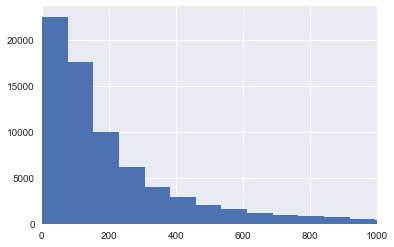

In [15]:
plt.hist(df2['reach_/_comments'], bins=1000)
plt.xlim(-.0004,1000)

(-0.03, 3)

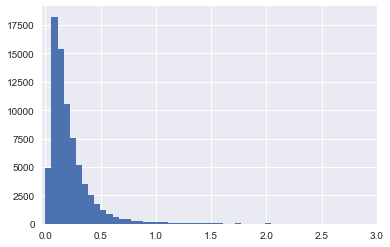

In [16]:
plt.hist(df2['reach_/_followers'], bins=1000)
plt.xlim(-.03,3)

(-0.003, 30)

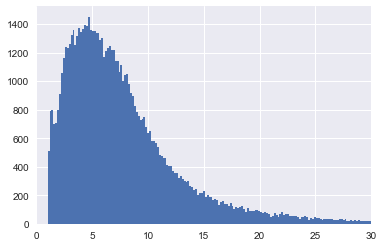

In [17]:
plt.hist(df2['reach_/_likes'], bins=1000)
plt.xlim(-.003, 30)

## Step 2 - Set confidence intervals for each ration

 *Just checking what some filters would look like without finding a confidence interval.* 

In [18]:
df2= df2.loc[(df2['reach_/_followers'] > df2['reach_/_followers'].quantile(.1))]
df2= df2.loc[(df2['reach_/_likes'] > df2['reach_/_likes'].quantile(.1))]
df2= df2.loc[(df2['reach_/_comments'] > df2['reach_/_comments'].quantile(.1))]

df2= df2.loc[(df2['reach_/_followers'] < df2['reach_/_followers'].quantile(.9))]
df2= df2.loc[(df2['reach_/_likes'] < df2['reach_/_likes'].quantile(.9))]
df2= df2.loc[(df2['reach_/_comments'] < df2['reach_/_comments'].quantile(.9))]

In [19]:
df2.head()

,followers,likes,comments,reach,reach_/_followers,reach_/_likes,reach_/_comments
142088,21968,315,8,4837,0.220184,15.355556,604.625000
425537,16003,210,8,1129,0.070549,5.376190,141.125000
435636,12849,907,43,2648,0.206086,2.919515,61.581395
609425,18441,446,13,2104,0.114094,4.717489,161.846154
252215,18590,315,14,1597,0.085906,5.069841,114.071429


Now, what does our data look like? 

(30, 650)

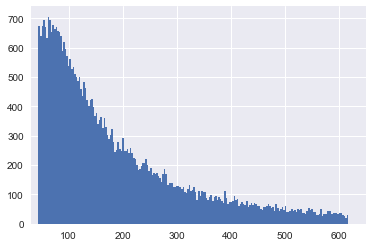

In [20]:
plt.hist(df2['reach_/_comments'], bins=200)
plt.xlim(30, 650)

(2, 17)

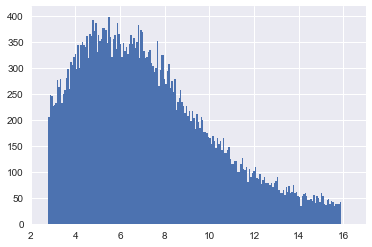

In [21]:
plt.hist(df2['reach_/_likes'], bins=200)
plt.xlim(2,17)

(0, 0.6)

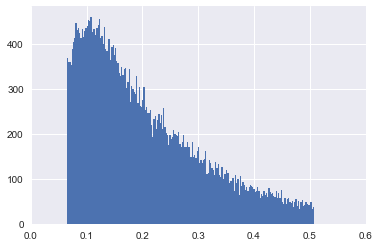

In [22]:
plt.hist(df2['reach_/_followers'], bins=200)
plt.xlim(0,.6)

# Fit the model

In [23]:
lr_model = ols(formula='reach~followers + likes + comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                 1.730e+04
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:53:47   Log-Likelihood:            -3.4692e+05
No. Observations:               40109   AIC:                         6.938e+05
Df Residuals:                   40105   BIC:                         6.939e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -244.2184     34.667     -7.045      0.000    -312.166    -176.271
followers      0.0892      0.002     45.606      0.000       0.085       0.093
likes          3.4767      0.023    149.851      0.000       3.431       3.522
comments      12.1297      0.359     33.765      0.000      11.426      12.834
==============================================================================
Omnibus:                     4168.441   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6083.711
Skew:                           0.799   Prob(JB):                         0.00
Kurtosis:                       4.041   Cond. No.                     9.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Scatterplots 
- Next we look at scatter plots of our data to further look for outliers and the correlation of our independent variable to our dependent variable. 

Text(0.5, 1.0, 'Followers CorrelatioScatter plot')

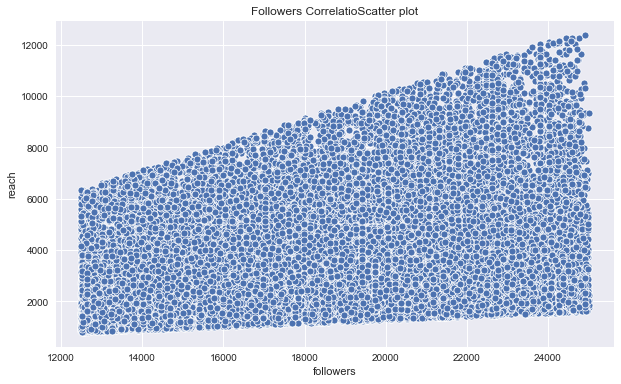

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2.followers, y=df2.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers CorrelatioScatter plot")

Text(0.5, 1.0, 'Likes Correlation Scatter plot')

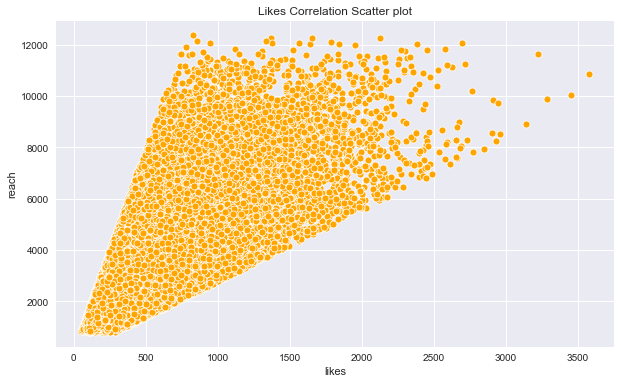

In [25]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.likes, color='orange' )
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Correlation Scatter plot")

Text(0.5, 1.0, 'Comments Correlation Scatter plot')

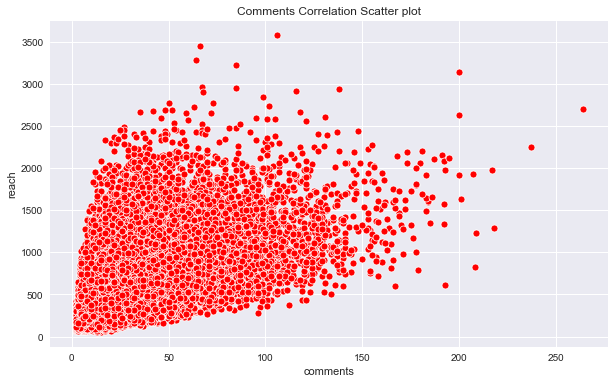

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.likes, x=df2.comments, color='red')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title("Comments Correlation Scatter plot")

Further we used Statsmodels to create an OLS model. This allows us to see all the import statistics and values associated with the three variables together. 

In [27]:
lr_model = ols(formula='reach~followers+likes+comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                 1.730e+04
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:53:50   Log-Likelihood:            -3.4692e+05
No. Observations:               40109   AIC:                         6.938e+05
Df Residuals:                   40105   BIC:                         6.939e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -244.2184     34.667     -7.045      0.000    -312.166    -176.271
followers      0.0892      0.002     45.606      0.000       0.085       0.093
likes          3.4767      0.023    149.851      0.000       3.431       3.522
comments      12.1297      0.359     33.765      0.000      11.426      12.834
==============================================================================
Omnibus:                     4168.441   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6083.711
Skew:                           0.799   Prob(JB):                         0.00
Kurtosis:                       4.041   Cond. No.                     9.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Check the model original data

In [28]:
df2['test_reach'] = round(lr_model.predict(df2),1)

In [29]:
df2['reach_diff'] = round(df2['reach'] - df2['test_reach'],1)

In [30]:
mean_squared_error(df2.reach, df2.test_reach)**.5

1380.8568010896568

## Test the Model

Create a quick function to run the coefficients from the three variables. 

### Add Test Reach to the original data Frame to check for accuracy

In [31]:
test['test_reach'] = round(lr_model.predict(test),1)

In [32]:
test['reach_diff'] = round(test['reach'] - test['test_reach'],1)

In [33]:
test.head()

,followers,likes,comments,reach,test_reach,reach_diff
317259,18762,499,4,4827,3213.3,1613.7
483813,19969,697,67,4655,4773.5,-118.5
553954,16425,233,16,2152,2225.5,-73.5
246019,23093,912,42,2267,5496.5,-3229.5
402400,14380,466,22,2373,2925.9,-552.9


In [34]:
test['diff_ratio'] = round((test.reach_diff / test.reach)*100, 1)

Text(0.5, 0, 'Error Percentage')

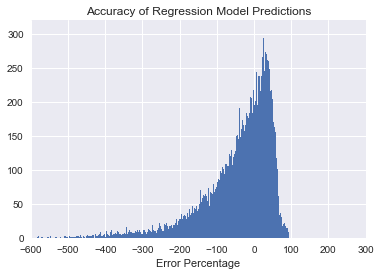

In [35]:
x = plt.hist(test.diff_ratio, bins = 1000)
plt.xlim(-600, 300)
plt.title("Accuracy of Regression Model Predictions")
plt.xlabel("Error Percentage")

In [36]:
mean_squared_error(test.reach, test.test_reach)**.5

5900.120654423726

In [37]:
test.describe()

,followers,likes,comments,reach,test_reach,reach_diff,diff_ratio
count,18871.000000,18871.000000,18871.000000,18871.000000,18871.000000,18871.000000,18871.00000
mean,17964.706481,635.528430,36.988024,4430.111123,4016.943315,413.167808,-44.04127
std,3654.898632,551.294635,70.994863,6776.415520,2367.555628,5885.792373,100.22404
min,12501.000000,10.000000,1.000000,107.000000,1006.300000,-45473.400000,-1850.70000
25%,14639.000000,278.000000,10.000000,1718.000000,2519.550000,-1446.850000,-83.10000
50%,17623.000000,490.000000,22.000000,2888.000000,3479.500000,-408.700000,-16.60000
75%,21199.500000,817.000000,44.000000,5192.000000,4821.450000,1117.300000,24.80000
max,24997.000000,10620.000000,3578.000000,282216.000000,49788.400000,263418.600000,94.30000


## Interactions.
Lets create a plot to see if the three variables are interacting with each other in the model. 

In [38]:
from sklearn.linear_model import LinearRegression
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

likes = df2["likes"].values.reshape(-1, 1)
comments = df2["comments"].values.reshape(-1, 1)
followers = df2["followers"].values.reshape(-1, 1)

regression_1.fit(likes, df2["reach"])
regression_2.fit(comments, df2["reach"])
regression_3.fit(followers, df2["reach"])

# Make predictions using the testing set
pred_1 = regression_1.predict(likes)
pred_2 = regression_2.predict(comments)
pred_3 = regression_3.predict(followers)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[4.14789429]
[44.9795347]
[0.19865224]


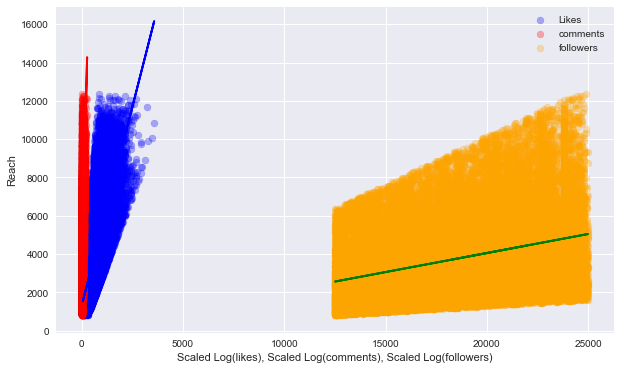

In [39]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(likes, df2["reach"],  color='blue', alpha = 0.3, label = "Likes")
plt.scatter(comments, df2["reach"],  color='red', alpha = 0.3, label = "comments")
plt.scatter(followers, df2["reach"],  color='orange', alpha = 0.3, label = "followers")

plt.plot(likes, pred_1,  color='blue', linewidth=2)
plt.plot(comments, pred_2,  color='red', linewidth=2)
plt.plot(followers, pred_3,  color='green', linewidth=2)
plt.ylabel("Reach")
plt.xlabel("Scaled Log(likes), Scaled Log(comments), Scaled Log(followers)")
plt.legend();

## Summary of users with 12.5k to 25k followers

After running this test, the model has an $R^2$ at .56 which is 17 points lower than our original reach test with users with 1 to 5,000 followers. We also have a RMSE of 1388.1 for the training data, although higher than the original reach test, it is still a decent result. However, our test data gave us a RMSE of 5461.25, which is much higher than the training data, due to the outliers in the data.